## Preprocess

In [112]:
import pandas as pd
import numpy as np
from datetime import datetime

In [113]:
df = pd.read_csv('../airflow/dags/data/resale_flats_transformed.csv')

/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_14591/292211018.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../airflow/dags/data/resale_flats_transformed.csv')


In [114]:
df.head()

,_id,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,street_name_with_block,postal,x,y,lat,lon,district
0,173917,3,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,01 TO 03,45.0,Improved,1986,60 years 11 months,300000.0,2024,172 ANG MO KIO AVE 4,560172,28349.920537,39632.219604,1.374694,103.836463,20.0
1,173918,3,ANG MO KIO,3 ROOM,308B,ANG MO KIO AVE 1,10 TO 12,70.0,Model A,2012,87 years 07 months,598000.0,2024,308B ANG MO KIO AVE 1,562308,29248.594650,38589.712063,1.365266,103.844538,20.0
2,173919,3,ANG MO KIO,3 ROOM,321,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1977,52 years 02 months,415000.0,2024,321 ANG MO KIO AVE 1,560321,29712.235084,38575.906775,1.365141,103.848704,20.0
3,173920,3,ANG MO KIO,3 ROOM,307C,ANG MO KIO AVE 1,10 TO 12,70.0,Model A,2012,87 years 07 months,601888.0,2024,307C ANG MO KIO AVE 1,563307,29318.866042,38622.316735,1.365561,103.845169,20.0
4,173921,3,ANG MO KIO,3 ROOM,549,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1981,55 years 11 months,380000.0,2024,549 ANG MO KIO AVE 10,560549,30681.283561,39463.114437,1.373165,103.857412,20.0


In [115]:
df.drop(['_id', 'town', 'street_name', 'street_name_with_block', 'postal', 'x', 'y', 'block', 'lease_commence_date'], axis=1, inplace=True)

In [116]:
def convert_remaining_lease(x):
    # example: "60 years 11 months"
    try:
        years = int(x.split(' ')[0])
        months = int(x.split(' ')[2])
    except IndexError:
        # print(x)
        return years * 12
    total_months = years * 12 + months
    return total_months

df['remaining_lease'] = df['remaining_lease'].apply(convert_remaining_lease)

In [117]:
def convert_date(x):
    return datetime(x['year'], x['month'], 1)

df['sale_date'] = df[['year', 'month']].apply(convert_date, axis=1)

In [118]:
categorical_vars = ['flat_type', 'storey_range', 'flat_model', 'district', 'month']
df = pd.get_dummies(df, columns=categorical_vars)

## Merge with cpi and sibor

In [119]:
# merge with cpi, sibor sora
cpi = pd.read_csv('../airflow/dags/data/cpi_with_lag_sma_ema.csv')
sibor = pd.read_csv('../airflow/dags/data/sibor_sora.csv')

In [120]:
sibor['SIBOR DATE'] = pd.to_datetime(sibor['SIBOR DATE'])
sibor.head()

/var/folders/dq/33rpc0cx4f54t0vx2cdcgczr0000gn/T/ipykernel_14591/2028583091.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sibor['SIBOR DATE'] = pd.to_datetime(sibor['SIBOR DATE'])


,SIBOR DATE,SIBOR 1M,SIBOR 3M,SIBOR 6M,SIBOR 12M,SOR ON,SOR 1M,SOR 3M,SOR 6M
0,2014-02-01,0.35369,0.40267,0.48191,0.59728,0.04964,0.15485,0.22406,0.28566
1,2014-03-01,0.35057,0.40267,0.48191,0.59728,0.06086,0.14516,0.21618,0.28373
2,2014-06-01,0.35520,0.40361,0.48191,0.59728,0.00742,0.15168,0.21708,0.28373
3,2014-07-01,0.35520,0.40361,0.48191,0.59728,-0.02376,0.14648,0.21829,0.28740
4,2014-08-01,0.35520,0.40461,0.48191,0.59728,-0.01223,0.14648,0.21980,0.28823


In [121]:
cpi['Month'] = pd.to_datetime(cpi['Month'])
cpi.head()

,Month,Value,cpi_lag1,cpi_lag3,cpi_lag6,cpi_lag12,cpi_sma3,cpi_sma6,cpi_sma12,cpi_ema3,cpi_ema6,cpi_ema12
0,1961-01-01,24.542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.542000,24.542000,24.542000
1,1961-02-01,24.565,24.542,NaN,NaN,NaN,NaN,NaN,NaN,24.553500,24.548571,24.545538
2,1961-03-01,24.585,24.565,24.542,NaN,NaN,24.564000,NaN,NaN,24.569250,24.558980,24.551609
3,1961-04-01,24.187,24.585,24.565,24.542,NaN,24.445667,NaN,NaN,24.378125,24.452700,24.495516
4,1961-05-01,24.053,24.187,24.585,24.565,NaN,24.275000,NaN,NaN,24.215563,24.338500,24.427436


In [122]:
# merge with df
df = df.merge(cpi, left_on='sale_date', right_on='Month', how='left')
df.drop('Month', axis=1, inplace=True)
df = df.merge(sibor, left_on='sale_date', right_on='SIBOR DATE', how='left')

# rename Value to cpi   
df.rename(columns={'Value': 'cpi'}, inplace=True)

df.drop('SIBOR DATE', axis=1, inplace=True)

In [123]:
# filter columns with dtype float64 or int64
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(num_cols)
to_remove = ['lat', 'lon']
num_cols = [col for col in num_cols if col not in to_remove]

Index(['floor_area_sqm', 'remaining_lease', 'resale_price', 'year', 'lat',
       'lon', 'cpi', 'cpi_lag1', 'cpi_lag3', 'cpi_lag6', 'cpi_lag12',
       'cpi_sma3', 'cpi_sma6', 'cpi_sma12', 'cpi_ema3', 'cpi_ema6',
       'cpi_ema12', 'SIBOR 1M', 'SIBOR 3M', 'SIBOR 6M', 'SIBOR 12M', 'SOR ON',
       'SOR 1M', 'SOR 3M', 'SOR 6M'],
      dtype='object')


In [128]:
train_split = df[df['sale_date'] < datetime(2023, 1, 1)]
test_split = df[df['sale_date'] >= datetime(2023, 1, 1)]

testing_dates = test_split['sale_date']

print(train_split.shape)
print(test_split.shape)


(143396, 107)
(32445, 107)


In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train_split[num_cols])

train_split_scaled = train_split.copy()
test_split_scaled = test_split.copy()
train_split_scaled[num_cols] = scaler.transform(train_split[num_cols])
test_split_scaled[num_cols] = scaler.transform(test_split[num_cols])

In [126]:
X_train, y_train = train_split_scaled.drop(['resale_price'], axis=1), train_split_scaled['resale_price']
X_test, y_test = test_split_scaled.drop(['resale_price'], axis=1), test_split_scaled['resale_price']

X_train.drop('sale_date', axis=1, inplace=True)
X_test.drop('sale_date', axis=1, inplace=True)

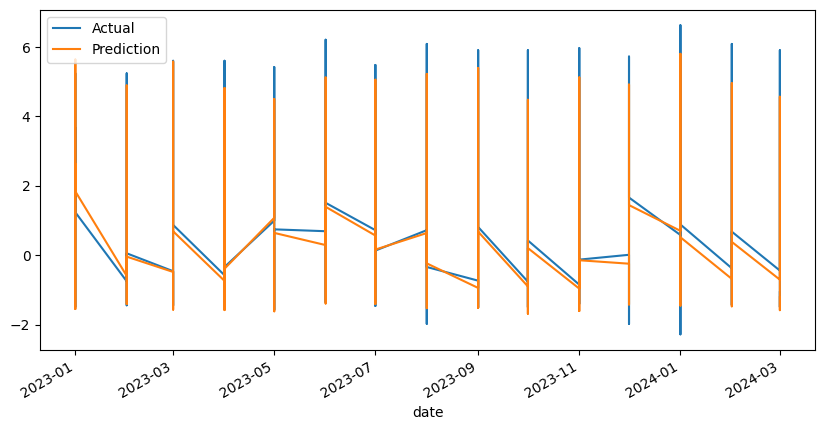

MAE: 0.19630337104889625
MSE: 0.07085355839569242
MAPE: 0.7824820738738789


In [129]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

plot_predictions(testing_dates, y_test, y_pred)
evaluate_model(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 143396, number of used features: 101
[LightGBM] [Info] Start training from score -0.000000


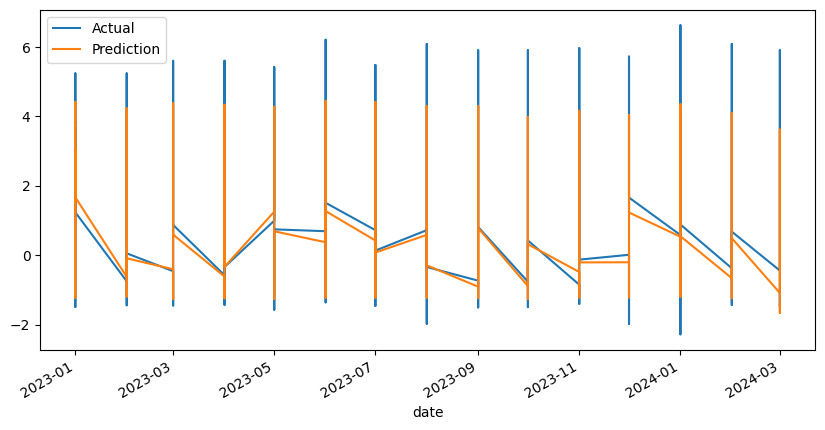

MAE: 0.25077306434017477
MSE: 0.1313070051825276
MAPE: 0.8338018959139062


In [131]:
import lightgbm as lgbm

lgb_model = lgbm.LGBMRegressor()
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
plot_predictions(testing_dates, y_test, y_pred)
evaluate_model(y_test, y_pred)

<font color="yellow">
In conclusion, XGBoost is the best model!
</font>